In [ ]:
! pip install --user --upgrade scipy numba
# ! pip install --user psutil

In [1]:
# TODO

# 1.
# Make non-linear in such a way that you cannot extrapolate to unseen P(Y,X)

# 2. 
# Use importance estimation to extrapolate.

# 3. 
# Show that when H|Z vs Z|H, extrapolation fails even with importance estimation. 

# 4
# Make true model such that excluding variables should recover a model that is "robust" (P(X|H))

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from trees import TransferTreeRegressor, build_tree, Node
from criteria import mse, transfer, causal_tree_criterion
from sklearn.preprocessing import PolynomialFeatures
from joblib import Parallel, delayed
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 3]

In [3]:
def plot_dat(vars_):
    f, axes = plt.subplots(len(vars_), 1, sharex=True, figsize=(20, 10))

    for (H,title),ax in zip(vars_, axes):
        for i,h in zip(['A', 'B', 'C', 'D'], H):
            sns.distplot(h, label = i, ax=ax)
        ax.legend()
        ax.set_title(title)
        
    # plt.title(title)
    # plt.show()


In [4]:
from trees import Leaf
leaf = Leaf(0,0,0,0)

def plot_split(node, X, tau, context_idxs):
    idx = X[:, node.dim] > node.thresh
    d = np.vstack([tau, idx, context_idxs]).T
    df = pd.DataFrame(d, columns = ['tau', 'split', 'ctx'])

    # sns.distplot(df)
    g = sns.FacetGrid(df, row = 'split', hue = 'ctx', aspect=5.0)
    g.map(sns.distplot, 'tau', bins=10, kde=False)
    plt.legend()

In [5]:
import numpy as np
from scipy.stats import gamma
import seaborn as sns
from copy import deepcopy

# Y := f(H, W, X, Z, N_Y)
# Y := f(W, X, Z, N_Y)
def fn(h, v, z, w):
    val = w*h + 0.5*w*z + np.random.normal(0, 0.5, size = h.shape[0])
    return val


def generate_data(N, fn, hidden_cause, plot, hiddens, v_conds, z_conds):
    # H is latent variable, distribution changes (not )
    H = [np.random.normal(loc=a, scale=b, size=N) for a,b in hiddens]

    # V := f(H, N_X)
    V = [c*h + np.random.normal(loc=a, scale=b, size=N) for h,(c,a,b) in zip(H, v_conds)]

    # if hidden_cause: 
    # H -> V, H -> Y
    # else:
    # V -> H, H -> Y
    if not hidden_cause:
        V,H = deepcopy(H), deepcopy(V)

    # Z = [gamma.rvs(int(np.random.normal(40, 10)), loc=0, scale=1, size=N) for h in H]
    # Z := f(N_Z) 
    Z = [np.random.normal(loc=a, scale=b, size=N) for h,(a,b) in zip(H, z_conds)]

    # W := f(N_W) -- TREATMENT
    W = [np.random.binomial(1, 0.5, size=N) for h in H]

    # Y:= fn(H, V, Z, W, N_Y)
    Y = [fn(H[idx], V[idx], Z[idx], W[idx]) for idx in range(4)]

    taus = [fn(h,v,z,1) - fn(h,v,z,0) for h,v,z in zip(H,V,Z)]
    
    if plot:
        plot_dat([(H,'H'), (V, 'V') , (Z, 'Z'), (Y, 'Y'), (taus, 'tau')])

    return [(y, np.array([w,v,z]).T, tau) for y,v,z,w,h,tau in zip(Y, V, Z, W, H, taus)]

In [6]:
from sklearn.metrics import mean_squared_error
from numba import njit

def flatten(a):
    return np.array([y for x in a for y in x])


def split_out_dat(dat):
    phi = PolynomialFeatures(degree=1, include_bias=False).fit_transform
    ys, Xs, taus = zip(*dat)

    ys_source, Xs_source = np.concatenate(ys[:-1]), np.concatenate(Xs[:-1])
    ys_target, Xs_target = ys[-1], Xs[-1]

    phi_source = phi(Xs_source[:, 1:])
    phi_target = phi(Xs_target[:, 1:])

    treatment = Xs_source[:, 0]
    N = ys[0].shape[0]

    context_idxs = np.array([j for i,_ in enumerate(ys[:-1]) for j in [i]*N])

    idx = np.arange(phi_source.shape[0])
    np.random.shuffle(idx)

    # print(phi_source.shape)
    # print(ys_source.shape)
    # print(treatment.shape)
    # print(context_idxs.shape)

    phi_source = phi_source[idx, :]
    ys_source = ys_source[idx]
    treatment = treatment[idx]
    context_idxs = context_idxs[idx]
    taus_source, taus_target = flatten(taus[:-1])[idx], taus[-1]

    return phi_source, phi_target, ys_source, treatment, context_idxs, taus_source, taus_target

def fit_models(phi_source, phi_target, ys_source, treatment, context_idxs, taus_source, taus_target):
    causal_model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              max_depth = 3, 
                              min_samples_leaf = 10, 
                              honest= True, 
                              alpha = 0.0)

    causal_model.fit(phi_source, 
                     ys_source, 
                     treatment=treatment,
                     min_samples=25,
                     var_weight=0.5)

    # causal_model.set_best_tree()
    causal_model.tree = causal_model.tree_path[0][1]

    transfer_model = TransferTreeRegressor(criterion = transfer,
                              max_depth = 3, 
                              min_samples_leaf = 10, 
                              honest= True, 
                              alpha = 0.0)

    transfer_model.fit(phi_source, 
                       ys_source, 
                       treatment=treatment,
                       context_idxs=context_idxs, 
                       target_X=phi_target,
                       min_samples=25,
                       mean_weight=0.025,
                       var_weight=0.025,
                       tau_var_weight=0.95,
                       wasserstein_weight=0.0,
                       importance=False)

    # transfer_model.set_best_tree()
    # transfer_model.tree
    transfer_model.tree = transfer_model.tree_path[0][1]

    tpreds = transfer_model.predict(phi_target, 0.95)
    cpreds = causal_model.predict(phi_target, 0.95)

    return (mean_squared_error(taus_target, tpreds[:, 0]), mean_squared_error(taus_target, cpreds[:, 0])), (tpreds, cpreds), (transfer_model, causal_model), (phi_source, phi_target, taus_source, taus_target, context_idxs)
    

In [24]:

v_conds = [(0.5,0,1), (1,0,1), (1.5,0,1), (-0.5,0,1)]
# v_conds = [(6,2,1)]*4
# v_conds = [(25,0,1)]*4
hiddens = [(10,1)]*4
# hiddens = [(10, 2), (14, 2), (18, 2), (22, 3)]
z_conds = [(2,2), (4,2), (6,2), (0,2)]


# z_conds = [(3, 1, 4), (3, 1, 4), (3, 1, 4), (4, 4, 4)]
# v_conds = [(6,2,5), (6,2,5), (6,2,5), (-3,2,8)]

def runrun(N):
    dat = generate_data(N,
                        fn, 
                        hidden_cause = True, 
                        plot = False, 
                        hiddens = hiddens,
                        v_conds = v_conds, 
                        z_conds = z_conds)

    return fit_models(*split_out_dat(dat))

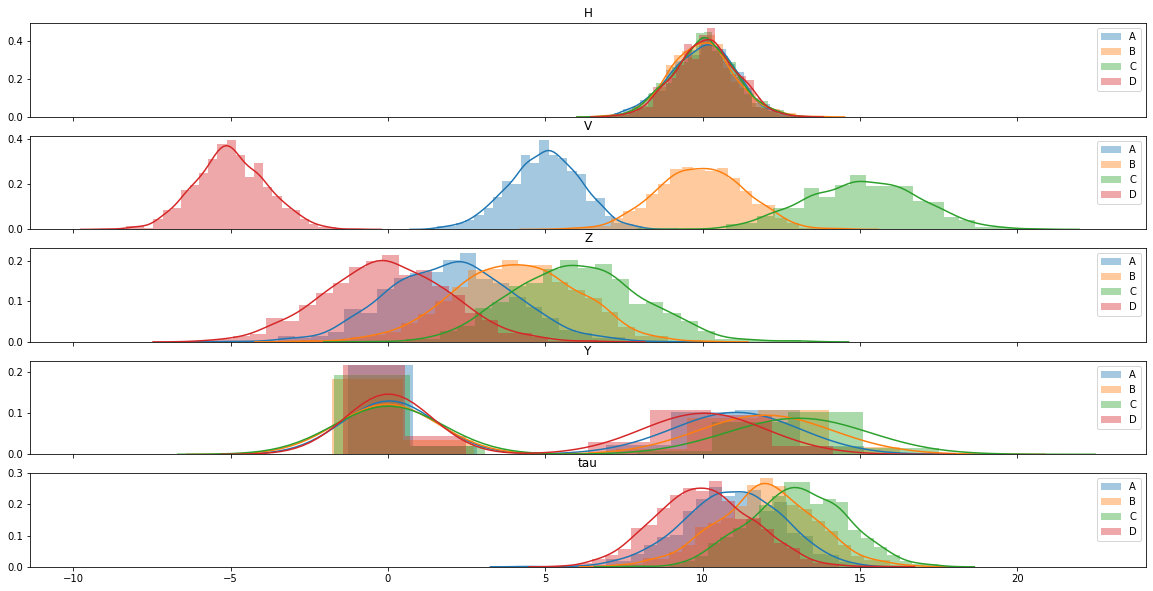

In [25]:
dat = generate_data(1000,
                    fn, 
                    hidden_cause = True, 
                    plot = True, 
                    hiddens = hiddens,
                    v_conds = v_conds, 
                    z_conds = z_conds)


In [26]:
ys, Xs, taus = zip(*dat)
phi_source, phi_target, _, _, _, taus_source, taus_target = split_out_dat(dat)

from sklearn.linear_model import LinearRegression

# LinearRegression().fit(Xs[0], ys[0]).coef_, LinearRegression().fit(Xs[1], ys[1]).coef_, LinearRegression().fit(Xs[2], ys[2]).coef_, LinearRegression().fit(Xs[3], ys[3]).coef_

LinearRegression().fit(Xs[0], taus[0]).coef_, LinearRegression().fit(Xs[1], taus[1]).coef_, LinearRegression().fit(Xs[2], taus[2]).coef_, LinearRegression().fit(Xs[3], taus[3]).coef_

(array([-0.00246194,  0.41110402,  0.51083346]),
 array([0.01641729, 0.52527566, 0.48978739]),
 array([0.0035369 , 0.43445367, 0.48392661]),
 array([ 0.01394536, -0.35044725,  0.50442401]))

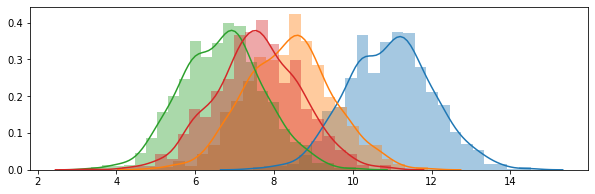

In [27]:
for d in [LinearRegression(fit_intercept=True).fit(Xs[i][:, 1:3], taus[i]).predict(Xs[0][:, 1:3]) for i in range(4)]:
    sns.distplot(d)

In [28]:
scores, preds, models, datt = runrun(1000)
tt, ct = models

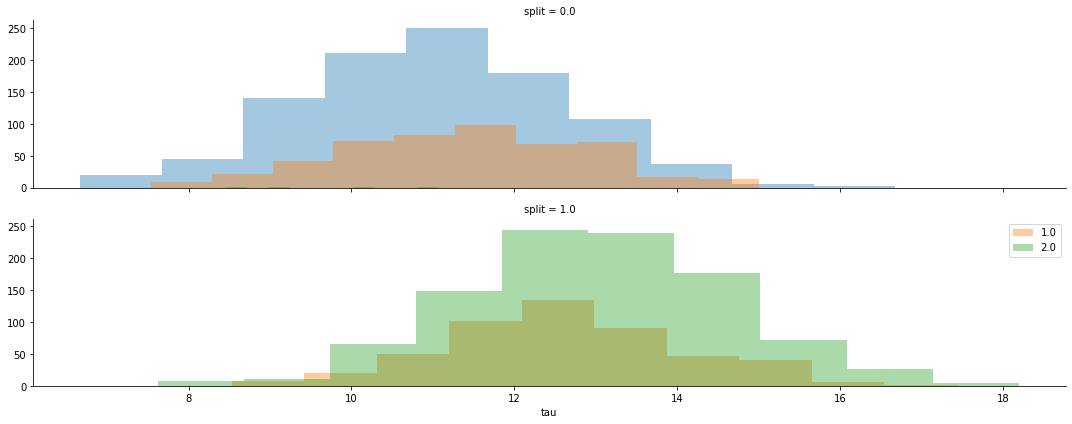

In [29]:
plot_split(tt.tree, datt[0], datt[2], datt[4])

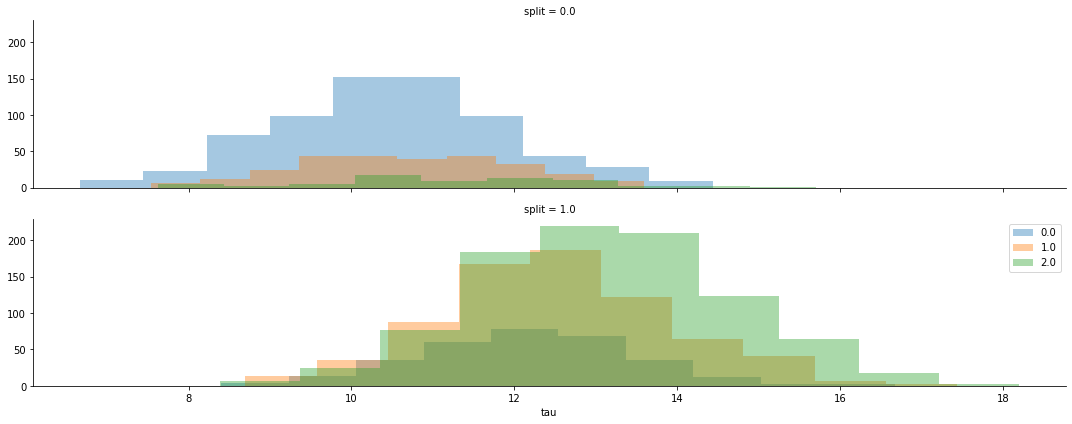

In [30]:
# plot_split(Node(leaf, 1, 5., leaf, leaf), datt[0], datt[2], datt[4])
plot_split(ct.tree, datt[0], datt[2], datt[4])

In [31]:
# from trees import split_data_by_thresh
# split_data_by_thresh(datt, tt.tree.dim, tt.tree.thresh)

tt.tree

|--dim: 0, thresh: 9.9511 scores: -1.460 || 141.736 || 0.008 || 0.657, gain: 0.3162, tot_gain: 0.3347 
   |--dim: 1, thresh: -0.4186 scores: -0.758 || 122.199 || 0.012 || 0.041, gain: 0.0102, tot_gain: 0.0122 
      |--pred: 8.9828, scores: -0.046 || 80.691 || 0.064 || 0.017, N: 69 
      |--dim: 0, thresh: 3.8072 scores: -0.722 || 126.917 || 0.011 || 0.010, gain: 0.0020, tot_gain: 0.0020 
         |--pred: 10.8700, scores: -0.069 || 118.156 || 0.095 || 0.000, N: 70 
         |--pred: 11.3169, scores: -0.655 || 128.073 || 0.013 || 0.005, N: 615 
   |--dim: 1, thresh: 2.5013 scores: -1.018 || 164.262 || 0.013 || 0.014, gain: 0.0056, tot_gain: 0.0063 
      |--pred: 10.8898, scores: -0.071 || 118.587 || 0.067 || 0.001, N: 72 
      |--dim: 0, thresh: 17.1428 scores: -0.952 || 169.596 || 0.013 || 0.001, gain: 0.0006, tot_gain: 0.0006 
         |--pred: 12.9759, scores: -0.871 || 168.373 || 0.014 || 0.004, N: 621 
         |--pred: 13.6713, scores: -0.082 || 186.905 || 0.165 || 0.000, N: 5

In [32]:
ct.tree

|--dim: 1, thresh: 2.9741 scores: -70.864 || 141.736 || 0.008, gain: 0.6042, tot_gain: 1.0351 
   |--dim: 1, thresh: -0.4186 scores: -18.848 || 108.753 || 0.013, gain: 0.0743, tot_gain: 0.1176 
      |--pred: 8.9615, scores: -1.872 || 80.308 || 0.064, N: 70 
      |--dim: 0, thresh: 5.3258 scores: -17.050 || 113.682 || 0.013, gain: 0.0433, tot_gain: 0.0433 
         |--pred: 10.4137, scores: -6.107 || 108.444 || 0.032, N: 169 
         |--pred: 10.8311, scores: -10.986 || 117.314 || 0.021, N: 281 
   |--dim: 0, thresh: 10.0147 scores: -52.620 || 161.089 || 0.009, gain: 0.1910, tot_gain: 0.3133 
      |--dim: 1, thresh: 5.1711 scores: -16.343 || 143.795 || 0.017, gain: 0.0563, tot_gain: 0.0563 
         |--pred: 11.7282, scores: -11.232 || 137.550 || 0.021, N: 245 
         |--pred: 12.7092, scores: -5.167 || 161.525 || 0.041, N: 96 
      |--dim: 0, thresh: 16.7291 scores: -36.468 || 171.223 || 0.013, gain: 0.0660, tot_gain: 0.0660 
         |--pred: 12.9671, scores: -31.273 || 168.146

In [16]:
# dim 0 should be ignored!

imp = lambda tt,ct: tt.feature_importance(gain=False)[1] - ct.feature_importance(gain=False)[1]

imp(tt, ct)

-0.30648352529940986

In [19]:
ts, cs = scores
(ts - cs)/cs

-0.021960729807326183

-0.20210512162277533
0.04958674642992528
CPU times: user 296 ms, sys: 124 ms, total: 420 ms
Wall time: 55.5 s


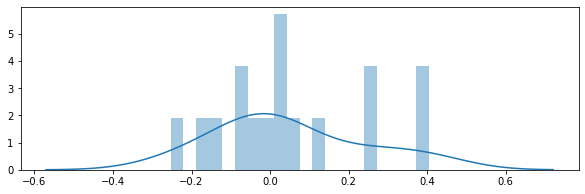

In [20]:
%%time
# N = 1000
imp = lambda tt,ct: tt.feature_importance(gain=False)[1] - ct.feature_importance(gain=False)[1]

results = Parallel(n_jobs=-1)(delayed(runrun)(1000) for i in range(16))
mse = [(t-c)/c for (t,c),_,(tt, ct),_ in results]
importances = [imp(tt, ct) for (t,c),_,(tt, ct),_ in results]
print(np.mean(importances))
print(np.mean(mse))
sns.distplot(np.array(mse), bins = 20)

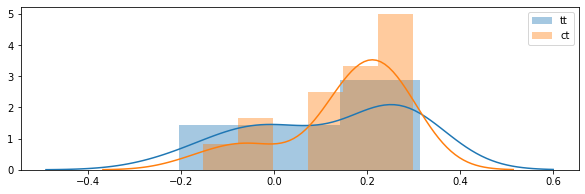

In [21]:
tau_var = [np.mean((np.mean(txx) - txx)**2) for _,_,_,(_,_,_,txx,_) in results]
t_mse, c_mse = zip(*[(t,c) for (t,c),_,(tt, ct),_ in results])
for lbl,d in zip(['tt', 'ct'], [[1-a/b for a,b in zip(t_mse, tau_var)], [1-a/b for a,b in zip(c_mse, tau_var)]]):
    sns.distplot(d, label=lbl)
plt.legend()

In [22]:
np.mean(np.array([[1-a/b for a,b in zip(t_mse, tau_var)], [1-a/b for a,b in zip(c_mse, tau_var)]]), 1)

array([0.11900239, 0.15419007])

In [23]:
def foo(results):
    taus = [txx for _,_,_,(_,_,_,txx,_) in results]
    tp, cp = zip(*[preds for _,preds,_,_ in results])

    tis = [get_within_ci(d,t) for d,t in zip(tp, taus)]
    cps = [get_within_ci(d,t) for d,t in zip(cp, taus)]

    return tis, cps


def get_within_ci(preds, taus):
    return pd.DataFrame(preds, columns = ['pred', 'lower', 'upper']) \
             .assign(true = taus) \
             .groupby('pred') \
             .apply(lambda df: df.assign(true_cate = df.true.mean())) \
             .pipe(lambda df: df.assign(within_int = (df.true_cate <= df.upper) & (df.true_cate >= df.lower))) \
             .pipe(lambda df: df['within_int'].sum() / df.shape[0])

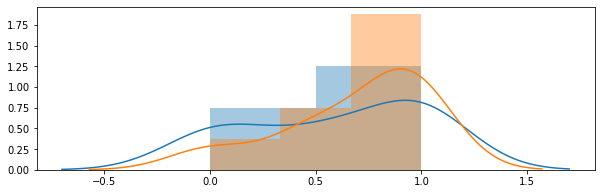

In [24]:
for a in foo(results):
    sns.distplot(a)

In [25]:
np.mean(foo(results)[0]), np.mean(foo(results)[1])

(0.5946875, 0.6974374999999999)

In [ ]:
# R2 score of predictions
cpreds = [causal_model.predict(phi(x[:, 1:])) for x in Xs]

[r2_score(t,p) for p,t in zip(cpreds, taus)]

In [675]:
# R2 score of predictions

tpreds = [transfer_model.predict(phi(x[:, 1:])) for x in Xs]

[r2_score(t,p) for p,t in zip(tpreds, taus)]

[0.48204475644637146,
 0.540050801439888,
 0.587036531032876,
 0.47988350972769966]

In [ ]:
[np.mean((t-p)**2) for p,t in zip(preds, taus)]

In [475]:
# Score of oracle average of sources on target

np.mean((np.mean(taus[:-1]) - taus[-1])**2)

1.6767703616462597

In [89]:
# score of oracle ATE from same source

[np.mean((np.mean(t) - t)**2) for t in taus]

[1511.704608424898, 3322.551749217693, 1561.6842105276883, 1085.0911237975392]

# Causal Tree Test

In [33]:
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

def make_nested_grid(params):
    return ParameterGrid({ key: list(ParameterGrid(value))
                           for key, value in params.items()})


def _crossval_score(model, X, y, treatment, weights, splitter, fit_params, init_params):
    model = deepcopy(model)
    model.set_params(**init_params)
    scores = []

    for train_idx, test_idx in splitter.split(X, treatment):
        model.fit(X[train_idx, :], 
                  y[train_idx], 
                  treatment = treatment[train_idx], 
                  sample_weight = weights[train_idx],
                  **fit_params)

        score = model.score(X[test_idx, :],
                            y[test_idx], 
                            treatment = treatment[test_idx], 
                            sample_weight = weights[test_idx],
                            **fit_params)
            
        scores.append(score)
    
    return np.mean(scores)

from joblib import Parallel, delayed

def model_search(model, X, y, treatment, weights, init_params, fit_params, splitter, n_jobs = -1):
    grid = make_nested_grid({'fit_params': fit_params, 
                             'init_params': init_params})

    all_scores = Parallel(n_jobs=n_jobs)(delayed(_crossval_score)(model, X, y, treatment, weights, splitter, **g) for g in grid)
    # all_scores = [_crossval_score(model, X, y, treatment, weights, splitter, **g) for g in grid]

    return list(zip(grid, all_scores))   

In [ ]:
import pandas as pd


def get_simulation(fi = 'simulation-1-athey.csv'):
    df = pd.read_csv(fi)
    X = df.iloc[:, :4].values
    y = df.y.values
    treatment = df.treatment.values
    return X, y, treatment

sim_X, sim_y, sim_treatment = get_simulation()

In [35]:
def eta(X):
    return 0.5 * X[:, 0] + X[:, 1]

def kappa(X):
    return 0.5 * X[:, 0]

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01)

N = 1000
S = round(N/2)
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
y = gen_y(X, treatment)

In [36]:
def eta(X):
    return 0.5 * np.sum(X[:, :2], axis=1) + np.sum(X[:, 2:], axis=1)

def kappa(X):
    return np.sum(X[:, :2] * (X[:, :2] > 0).astype(int), axis=1)

def gen_y(X, w):
    return eta(X) + 0.5 * (2*w - 1) * kappa(X) + np.random.normal(0, 0.01, size = X.shape[0])


N = 12000
S = 2000
X = np.random.normal(0, 1, (N, 6))
treatment = np.random.binomial(1, 0.5, N)
weights = np.ones(N)
y = gen_y(X, treatment)

In [37]:
sim_dat = pd.concat([pd.DataFrame(X, columns = range(1, 7)), 
                     pd.DataFrame({ 'y': y, 'treatment': treatment, 'tau': kappa(X)})], axis=1)

sim_dat.to_csv('sim_dat-2.csv', index=False)

In [64]:
# idx = np.arange(X.shape[0])
# np.random.shuffle(idx)

# treatment = treatment[idx]
# X = X[idx, :]
# y = y[idx]

In [38]:
%%time

from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 3)

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 4,
                              alpha = 0.1, 
                              honest = False)

fit_params = {'min_samples': [25] }
init_params = {'alpha': [ -.1, -0.05, -0.01, 0.0, 0.01, 0.05, 0.1, 0.4 ], 'honest': [True] }

results = model_search(model, X[:S], y[:S], treatment[:S], weights[:S], init_params, fit_params, cv)

best_params = sorted(results, key = lambda t: t[1])[0][0]['init_params']

best_params

CPU times: user 180 ms, sys: 108 ms, total: 288 ms
Wall time: 9.79 s


{'alpha': -0.01, 'honest': True}

In [52]:
from sklearn.metrics import r2_score

model = TransferTreeRegressor(criterion = causal_tree_criterion, 
                              min_samples_leaf = 4,
                              alpha = 0.1, 
                              honest = False)

# model.set_params(**best_params)
model.set_params(alpha = 0.0, honest=True)

model.fit(X[:S], y[:S], treatment=treatment[:S], min_samples=25, var_weight = 0.5)

print(r2_score(kappa(X[S:]), model.predict(X[S:])))

model.tree

0.005000776232677695


|--dim: 0, thresh: 0.5946 scores: -0.707 || 1.450 || 0.036, gain: 0.1639, tot_gain: 0.2241 
   |--dim: 5, thresh: 1.3121 scores: -0.195 || 0.608 || 0.049, gain: 0.0025, tot_gain: 0.0602 
      |--dim: 3, thresh: 1.1859 scores: -0.190 || 0.663 || 0.052, gain: 0.0413, tot_gain: 0.0577 
         |--dim: 5, thresh: -1.0508 scores: -0.246 || 0.935 || 0.051, gain: -0.0345, tot_gain: 0.0165 
            |--pred: 0.6024, scores: -0.006 || 0.363 || 0.240, N: 105 
            |--dim: 1, thresh: 0.5871 scores: -0.205 || 0.964 || 0.057, gain: 0.0419, tot_gain: 0.0510 
               |--pred: 0.7730, scores: -0.092 || 0.598 || 0.068, N: 346 
               |--dim: 4, thresh: -0.2261 scores: -0.155 || 3.198 || 0.268, gain: 0.0091, tot_gain: 0.0091 
                  |--pred: 0.8066, scores: -0.003 || 0.651 || 0.515, N: 46 
                  |--pred: 2.3930, scores: -0.161 || 5.727 || 0.351, N: 60 
         |--pred: -0.0358, scores: 0.015 || 0.001 || 0.466, N: 64 
      |--pred: 0.7757, scores: -0.00

In [53]:
preds = pd.DataFrame(model.predict(X[S:], interval = 0.975), columns = ['pred', 'lower', 'upper'])

preds.assign(true = kappa(X[S:])) \
    .groupby('pred') \
    .apply(lambda df: df.assign(true_cate = df.true.mean())) \
    .pipe(lambda df: df.assign(within_int = (df.true_cate <= df.upper) & (df.true_cate >= df.lower))) \
    .pipe(lambda df: df['within_int'].sum() / df.shape[0])

0.2976

In [ ]:
model = TransferTreeRegressor(criterion = mse, max_depth = 5, min_samples_leaf = 10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
# np.mean((preds - y)**2)

np.histogram(preds)

In [60]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10)

model.fit(phi(X), y, sample_weight = weights)
preds = model.predict(phi(X))
np.mean((preds - y)**2)

(array([  15,    0,   41,   23,   95,   47,   87,  103,  406, 1183]),
 array([-129.40835129, -116.21549089, -103.02263049,  -89.82977009,
         -76.63690969,  -63.44404929,  -50.25118889,  -37.05832849,
         -23.86546809,  -10.67260769,    2.52025272]))

In [34]:
model = DecisionTreeRegressor(max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [35]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [36]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.7473, 32.487 , 11.613 ,  4.5725])

In [37]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([12.42759, 25.75614,  5.67631,  3.50874])

In [38]:
model = TransferTreeRegressor(criterion=mse, max_depth=4, min_samples_leaf=20)

np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True) for i in range(10)]), 0)

array([ 0.3661, 20.3762,  0.4404,  7.6768])

In [39]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = None, model_search = False) for i in range(10)]), 0)

array([ 0.3656, 41.3072, 15.5   ,  1.5563])

In [52]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True) for i in range(10)]), 0)

array([11.3818, 32.1958, 11.2033,  3.5604])

In [51]:
np.mean(np.array([run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = False) for i in range(10)]), 0)

array([10.9098,  4.9235,  3.2745,  3.7268])

In [42]:
model = LinearRegression(fit_intercept=False)
run_model(dat, model, phi, 0, 1, use_weights = None, model_search = False)

[0.3605, 21.2762, 16.201, 7.1304]

In [31]:
run_model(dat, model, phi, 0, 3, use_weights = None, model_search = True)

[0.4141, 20.8479, 0.2354, 6.2956]

In [32]:
run_model(dat, model, phi, 0, 1, use_weights = 1, model_search = False)

[12.3876, 41.752, 16.8672, 4.4122]

In [33]:
run_model(dat, model, phi, 0, 3, use_weights = 1, model_search = True)

[11.362, 31.8239, 11.2857, 4.7136]

In [1802]:
# get residuals for "sets" separately
# compute distance between residuals
# optimize squared errors + penalty for residual distance

# search for "sets" by looking at residuals and fitting a mixture model
# then optimize to remove that mixture...

# set up an adversarial problem: the adversary tries to find a 
# mixture model in your reiduals, the classifier tries to make force the
# adversary to fit a 1-component mixture, for example... 